In [168]:
import streamlit as st

import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
mpl.rcParams['figure.figsize'] = (18,12)

import psycopg2
import sys

import math

import plotly.express as px
import plotly.graph_objects as go

import holidays

sns.set()
sns.set_style('whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from sklearn import linear_model as lm

import pickle

import pmdarima as pm

In [3]:
param_dic = {
    "host"      : "localhost",
    "database"  : "demand",
    "user"      : "postgres",
    "password"  : "password"
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    tupples = cursor.fetchall()
    cursor.close()
    
    data = pd.DataFrame(tupples, columns=column_names)
    return data

In [117]:
def deal_with_holidays(data,end_year,start_year='2018'):
    holiday = holidays.Canada()
    hol_list = holiday[start_year:str(end_year)]
    for date in hol_list:
        data.loc[datetime.strftime(date,'%Y-%m-%d'),'holiday_idx'] = 1
        
def deal_with_dayofweek(x):
    if x == 'Weekday':
        return 1
    else:
        return 0
    
def deal_with_temperature(x):
    if x == 'Hot':
        return 1
    else:
        return 0

In [118]:
conn = connect(param_dic)

column_names = ['timestamp', 'hour', 'temp_index', 'week_index', 'temperature', 'demand']

query = ("SELECT temp_data.timestamp,hour,temp_index,week_index,temperature,demand_data.demand" 
         " FROM temp_data LEFT JOIN demand_data ON temp_data.timestamp = demand_data.timestamp"
         " ORDER BY timestamp")


data = postgresql_to_dataframe(conn, query, column_names)
data.set_index('timestamp',inplace=True)

Connecting to the PostgreSQL database...
Connection successful


In [119]:
data.dropna(inplace=True)

In [120]:
display(data.head())
display(data.shape)

,hour,temp_index,week_index,temperature,demand
timestamp,,,,,
2018-01-01 00:00:00,0,NotHot,Weekday,-19.5,5340.0
2018-01-01 01:00:00,1,NotHot,Weekday,-21.7,5211.0
2018-01-01 02:00:00,2,NotHot,Weekday,-19.3,5096.0
2018-01-01 03:00:00,3,NotHot,Weekday,-20.3,4987.0
2018-01-01 04:00:00,4,NotHot,Weekday,-19.9,4926.0


(27501, 5)

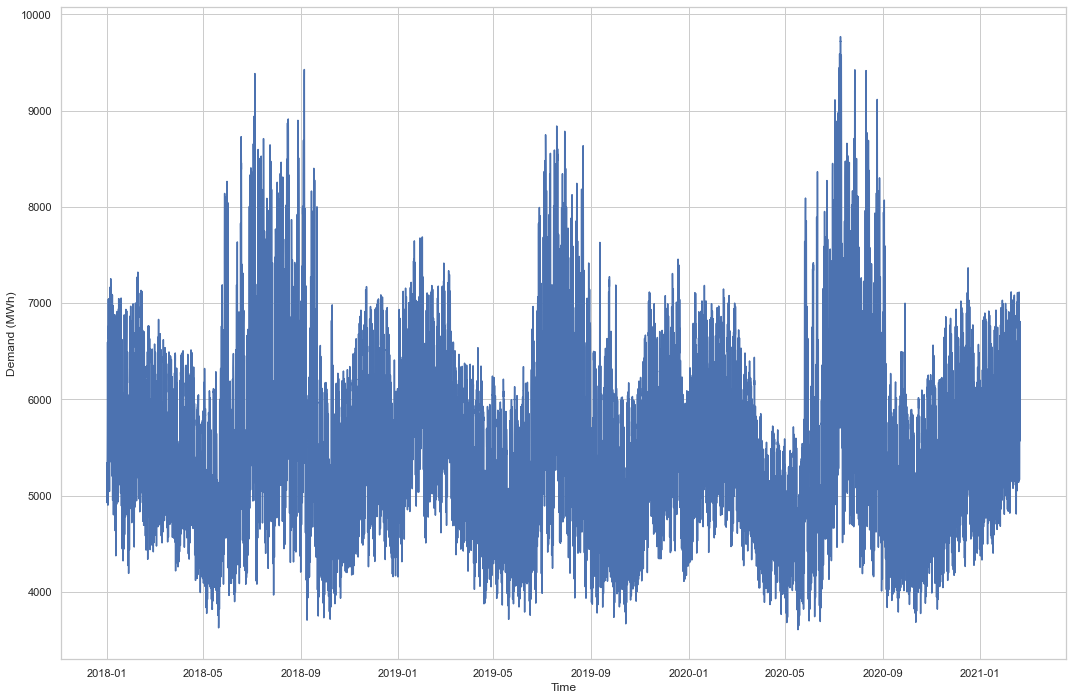

In [79]:
sns.lineplot(x='timestamp',y='demand',data=data.reset_index());
plt.xlabel('Time');
plt.ylabel('Demand (MWh)');

In [122]:
data['holiday_idx'] = 0
end_year = data.reset_index().iloc[-1]['timestamp'].year
data['week_index'] = data['week_index'].map(deal_with_dayofweek)
data['temp_index'] = data['temp_index'].map(deal_with_temperature)
deal_with_holidays(data,end_year)
data.drop(['hour'],axis=1,inplace=True)

In [123]:
display(data.head())
display(data.shape)

,temp_index,week_index,temperature,demand,holiday_idx
timestamp,,,,,
2018-01-01 00:00:00,0,1,-19.5,5340.0,0
2018-01-01 01:00:00,0,1,-21.7,5211.0,0
2018-01-01 02:00:00,0,1,-19.3,5096.0,0
2018-01-01 03:00:00,0,1,-20.3,4987.0,0
2018-01-01 04:00:00,0,1,-19.9,4926.0,0


(27501, 5)

In [124]:
data_1 = data.copy()
data.drop(['holiday_idx','temperature','week_index','temp_index'],axis=1,inplace=True)

In [125]:
display(data.head())
display(data.shape)

,demand
timestamp,
2018-01-01 00:00:00,5340.0
2018-01-01 01:00:00,5211.0
2018-01-01 02:00:00,5096.0
2018-01-01 03:00:00,4987.0
2018-01-01 04:00:00,4926.0


(27501, 1)

In [12]:
def fourier_terms_year(df,ky):
    
    """
    Takes in a dataframe and returns the dataframe with 2*ky fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    return data

def fourier_terms_year_week(df,ky,kw):
    
    """
    Takes in a dataframe and returns the dataframe with 2*(ky+kw) fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    for w in range(1,kw+1):
        data['sin_week'+str(w)] = np.sin(2*w*np.pi*data.index.dayofweek/7)
        data['cos_week'+str(w)] = np.cos(2*w*np.pi*data.index.dayofweek/7)

    return data

def fourier_terms_year_week_day(df,ky,kw,kd):
    
    """
    Takes in a dataframe and returns the dataframe with 2*(ky+kw+kd) fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    for w in range(1,kw+1):
        data['sin_week'+str(w)] = np.sin(2*w*np.pi*data.index.dayofweek/7)
        data['cos_week'+str(w)] = np.cos(2*w*np.pi*data.index.dayofweek/7)

    for d in range(1,kd+1):
        data['sin_hour'+str(d)] = np.sin(2*d*np.pi*data.index.hour/24)
        data['cos_hour'+str(d)] = np.cos(2*d*np.pi*data.index.hour/24) 

    return data


def fourier_terms_year_day(df,ky,kd):
    
    """
    Takes in a dataframe and returns the dataframe with 2*(ky+kd) fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    for d in range(1,kd+1):
        data['sin_hour'+str(d)] = np.sin(2*d*np.pi*data.index.hour/24)
        data['cos_hour'+str(d)] = np.cos(2*d*np.pi*data.index.hour/24) 

    return data


def my_data(data,pred_start):
    
    """
    Takes in a dataframe and a start date for predictions and performs a train test split
    """
    
    train_end = (datetime.strptime(pred_start,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
    
    pred_day = data.loc[pred_start:]
    train_days = data.loc[:train_end]
    
    y_train = train_days['demand'].to_numpy().reshape(-1, 1)
    X_train = train_days.loc[:, train_days.columns != 'demand']
    y_test = pred_day['demand'].to_numpy().reshape(-1, 1)
    X_test = pred_day.loc[:, pred_day.columns != 'demand']
    
    return X_train, X_test, y_train, y_test

The value of K: (75)


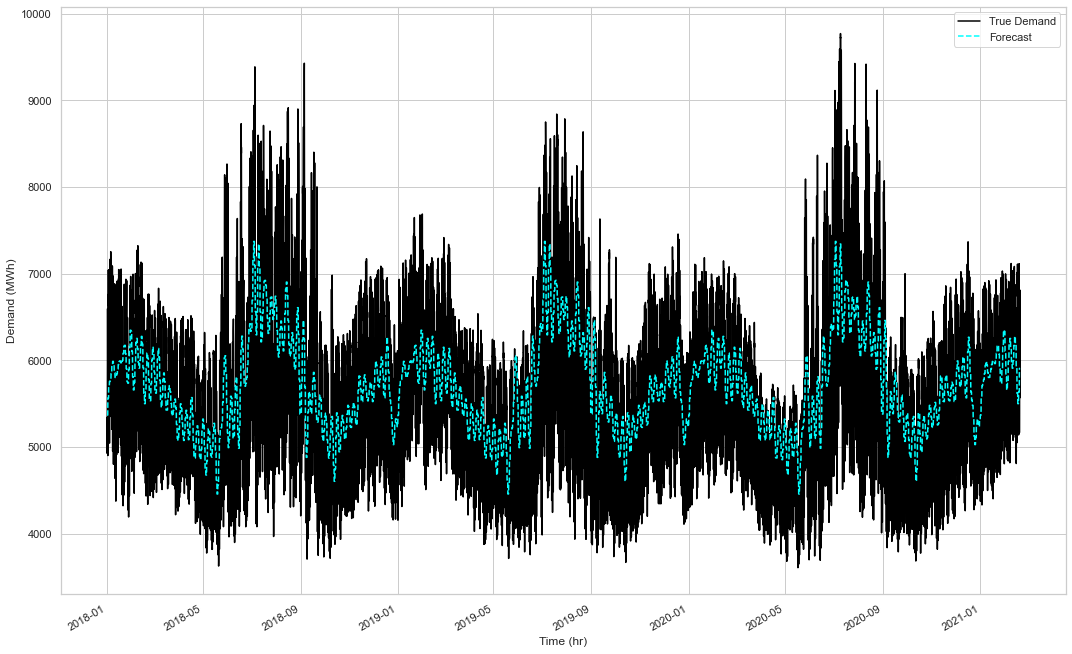

In [13]:
myterms = [5,10,15,25,60,75,80,90]
aic = []

for K in myterms:
    
    df = fourier_terms_year(data,K)
    
    demand = df.pop('demand')
    df['demand'] = demand
    X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')
    
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train).fit()
    
    aic.append(model.aic)
    
K_1 = myterms[np.argmin(aic)]

df_1 = fourier_terms_year(data,K_1)

df_1['demand'] = df_1.pop('demand')
X_train_1, X_test_1, y_train_1, y_test_1 = my_data(df_1,'2021-01-20')

X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

model_1 = sm.OLS(y_train_1,X_train_1).fit()
    
predictions_1 = model_1.predict(X_test_1)

print(f'The value of K: ({K_1})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_1.predict(sm.add_constant(df_1.loc[:, df_1.columns != 'demand'])),label='Forecast',color='aqua',linestyle='dashed')    
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

The value of K: ((75, 5))


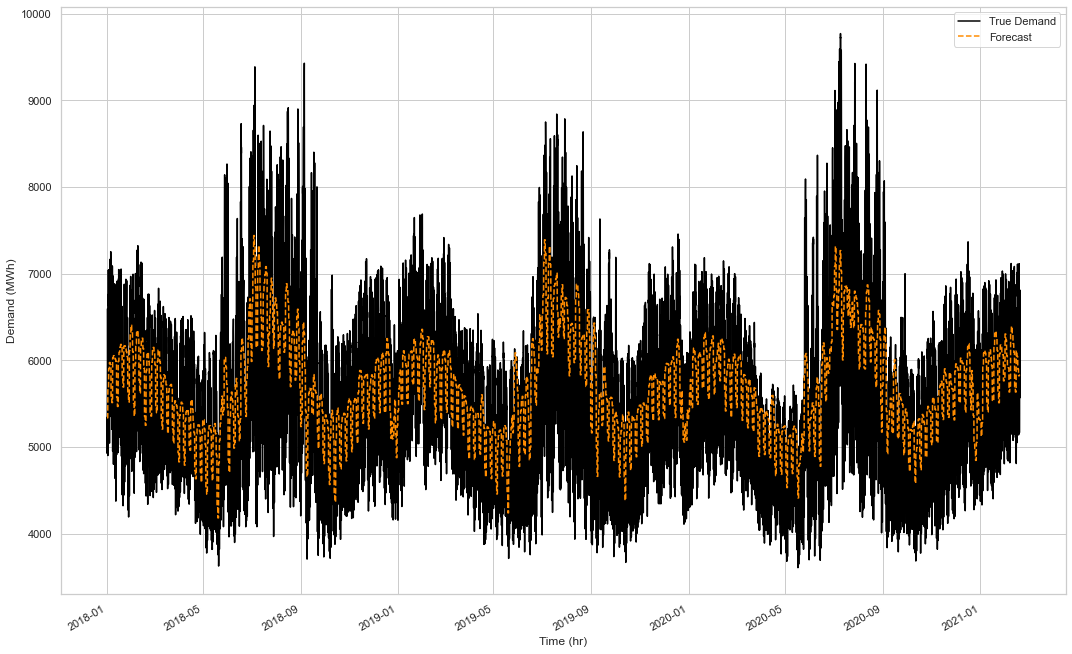

In [14]:
myterms_1 = [5,10,15,25,60,75,80,90]
myterms_2 = [2,5,7]

aic = np.zeros((len(myterms_1),len(myterms_2)))

for i,K1 in enumerate(myterms_1):
    for j,K2 in enumerate(myterms_2):
    
        df = fourier_terms_year_week(data,K1,K2)

        demand = df.pop('demand')
        df['demand'] = demand
        X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.OLS(y_train,X_train).fit()
    
        aic[i][j] = model.aic
        
K1_2 = myterms_1[math.floor(aic.argmin()/len(myterms_2))]
K2_2 = myterms_2[aic.argmin() - (math.floor(aic.argmin()/3))*len(myterms_2)]

df_2 = fourier_terms_year_week(data,K1_2,K2_2)

df_2['demand'] = df_2.pop('demand')

X_train_2, X_test_2, y_train_2, y_test_2 = my_data(df_2,'2021-01-20')

X_train_2 = sm.add_constant(X_train_2)
X_test_2 = sm.add_constant(X_test_2)

model_2 = sm.OLS(y_train_2,X_train_2).fit()
predictions_2 = model_2.predict(X_test_2)

print(f'The value of K: ({K1_2,K2_2})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_2.predict(sm.add_constant(df_2.loc[:, df_2.columns != 'demand'])),label='Forecast',color='darkorange',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

The value of K: ((90, 5, 5))


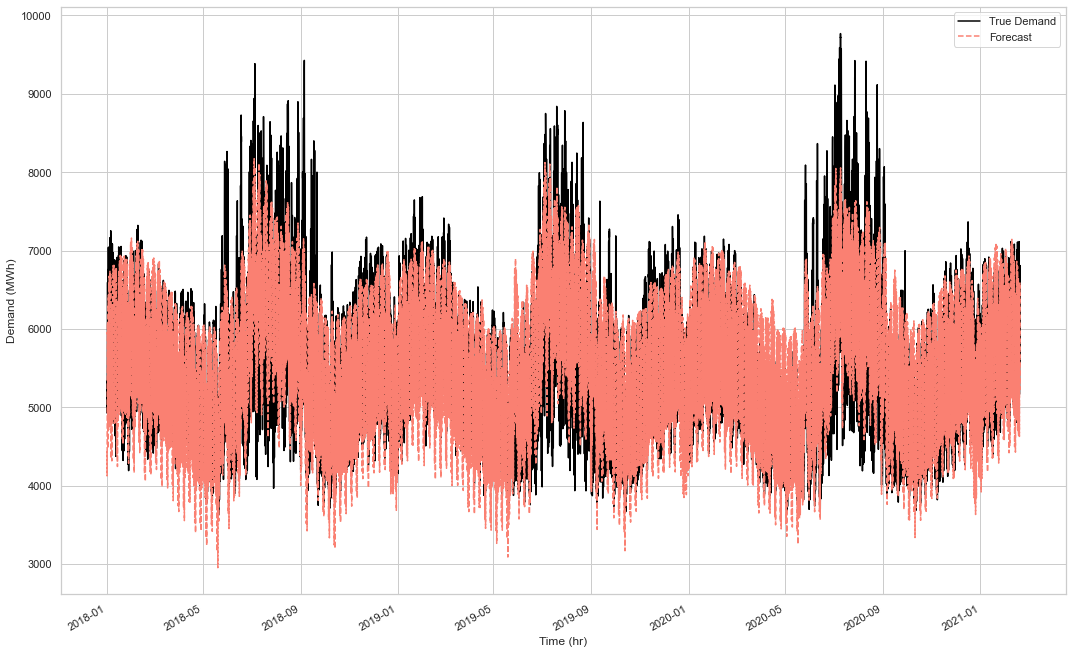

In [86]:
myterms_1 = [75,80,90]
myterms_2 = [2,5,7]
myterms_3 = [5,10]

aic = np.zeros((len(myterms_1),len(myterms_2),len(myterms_3)))

for i,K1 in enumerate(myterms_1):
    for j,K2 in enumerate(myterms_2):
        for k,K3 in enumerate(myterms_3):
    
            df = fourier_terms_year_week_day(data,K1,K2,K3)

            demand = df.pop('demand')
            df['demand'] = demand
            X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')

            X_train = sm.add_constant(X_train)
            X_test = sm.add_constant(X_test)

            model = sm.OLS(y_train,X_train).fit()

            aic[i][j][k] = model.aic
        
K1_3 = myterms_1[math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))]
K2_3 = myterms_2[math.floor((np.argmin(aic) - math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))*(len(myterms_2)*len(myterms_3)))/(len(myterms_3)))]
K3_3 = myterms_3[np.argmin(aic) - math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))*(len(myterms_2)*len(myterms_3)) - math.floor((np.argmin(aic) - math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))*(len(myterms_2)*len(myterms_3)))/(len(myterms_3))*(len(myterms_3)))]

df_3 = fourier_terms_year_week_day(data,K1_3,K2_3,K3_3)

df_3['demand'] = df_3.pop('demand')

X_train_3, X_test_3, y_train_3, y_test_3 = my_data(df_3,'2021-01-20')

X_train_3 = sm.add_constant(X_train_3)
X_test_3 = sm.add_constant(X_test_3)

model_3 = sm.OLS(y_train_3,X_train_3).fit()
predictions_3 = model_3.predict(X_test_3)

print(f'The value of K: ({K1_3,K2_3,K3_3})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_3.predict(sm.add_constant(df_3.loc[:, df_3.columns != 'demand'])),label='Forecast',color='salmon',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

The value of K: ((90, 5))


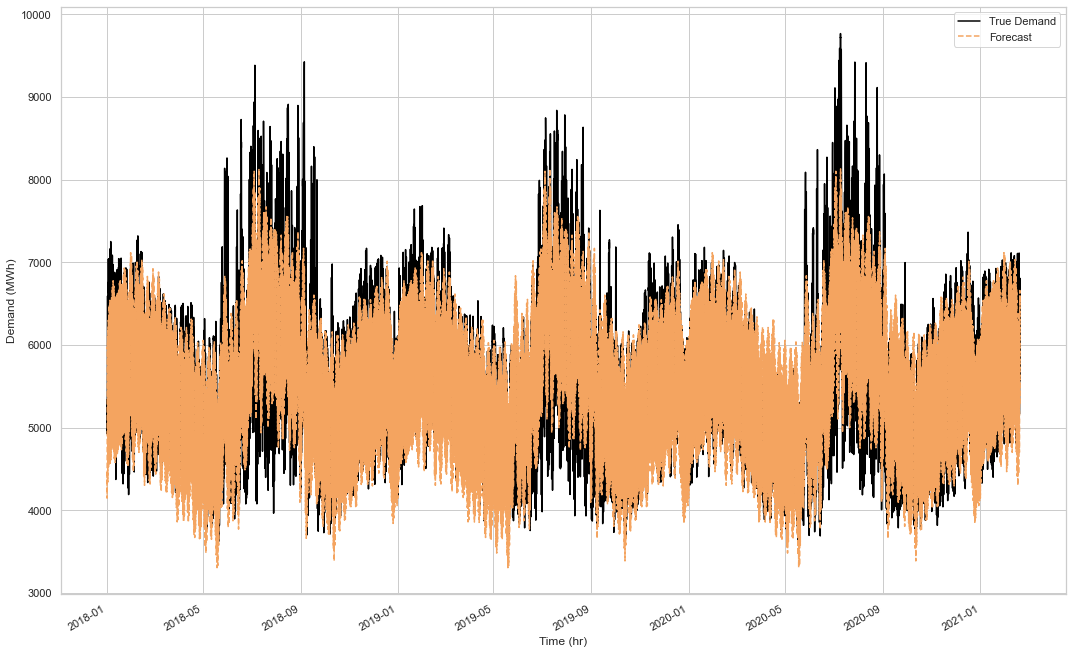

In [16]:
myterms_1 = [5,10,15,25,60,75,80,90]
myterms_2 = [5,10,15,20]

aic = np.zeros((len(myterms_1),len(myterms_2)))

for i,K1 in enumerate(myterms_1):
    for j,K2 in enumerate(myterms_2):
    
        df = fourier_terms_year_day(data,K1,K2)

        demand = df.pop('demand')
        df['demand'] = demand
        X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.OLS(y_train,X_train).fit()
    
        aic[i][j] = model.aic
        
K1_4 = myterms_1[math.floor(aic.argmin()/len(myterms_2))]
K2_4 = myterms_2[aic.argmin() - (math.floor(aic.argmin()/len(myterms_2)))*len(myterms_2)]

df_4 = fourier_terms_year_day(data,K1_4,K2_4)

df_4['demand'] = df_4.pop('demand')

X_train_4, X_test_4, y_train_4, y_test_4 = my_data(df_4,'2021-01-20')

X_train_4 = sm.add_constant(X_train_4)
X_test_4 = sm.add_constant(X_test_4)

model_4 = sm.OLS(y_train_4,X_train_4).fit()
predictions_4 = model_4.predict(X_test_4)

print(f'The value of K: ({K1_4,K2_4})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_4.predict(sm.add_constant(df_4.loc[:, df_4.columns != 'demand'])),label='Forecast',color='sandybrown',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [126]:
data_2 = data_1.copy()
data_1['temperature'] = data_1.pop('temperature')
display(data_1.head())
display(data_1.shape)

,temp_index,week_index,demand,holiday_idx,temperature
timestamp,,,,,
2018-01-01 00:00:00,0,1,5340.0,0,-19.5
2018-01-01 01:00:00,0,1,5211.0,0,-21.7
2018-01-01 02:00:00,0,1,5096.0,0,-19.3
2018-01-01 03:00:00,0,1,4987.0,0,-20.3
2018-01-01 04:00:00,0,1,4926.0,0,-19.9


(27501, 5)

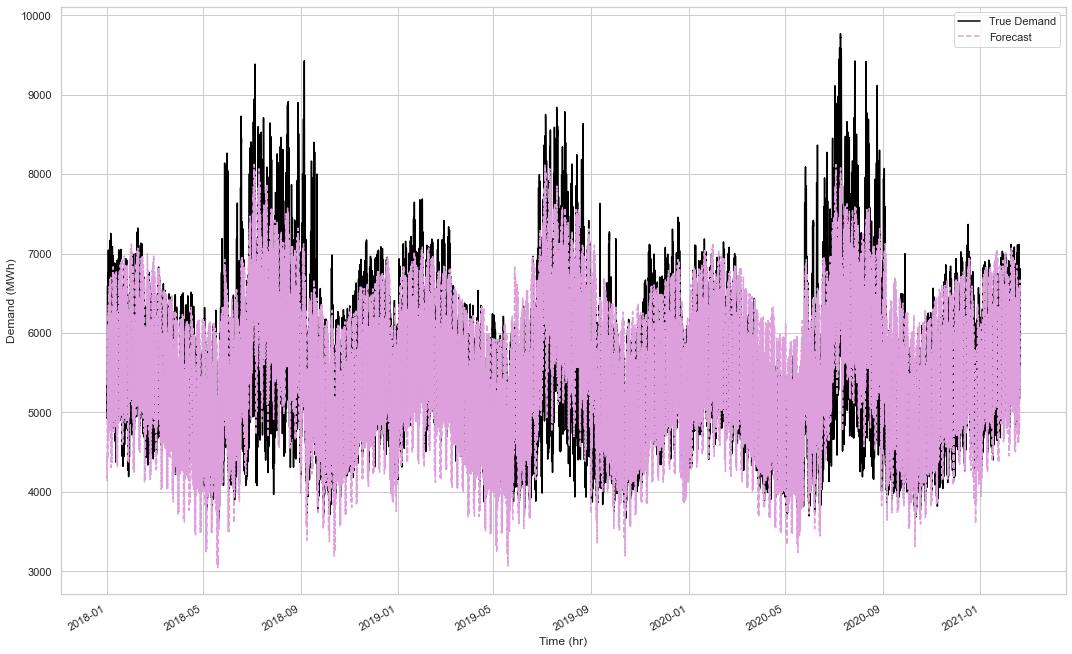

In [54]:
df_5 = fourier_terms_year_day(data_1,K1_4,K2_4)

df_5['demand'] = df_5.pop('demand')

X_train_5, X_test_5, y_train_5, y_test_5 = my_data(df_5,'2021-01-20')

X_train_5 = sm.add_constant(X_train_5)
X_test_5 = sm.add_constant(X_test_5)

model_5 = sm.OLS(y_train_5,X_train_5).fit()
predictions_5 = model_5.predict(X_test_5)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_5.predict(sm.add_constant(df_5.loc[:, df_5.columns != 'demand'])),label='Forecast',color='plum',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [127]:
data_3 = data_2.copy()
data_2.drop(['week_index'],axis=1,inplace=True)
display(data_2.head())
display(data_2.shape)

,temp_index,temperature,demand,holiday_idx
timestamp,,,,
2018-01-01 00:00:00,0,-19.5,5340.0,0
2018-01-01 01:00:00,0,-21.7,5211.0,0
2018-01-01 02:00:00,0,-19.3,5096.0,0
2018-01-01 03:00:00,0,-20.3,4987.0,0
2018-01-01 04:00:00,0,-19.9,4926.0,0


(27501, 4)

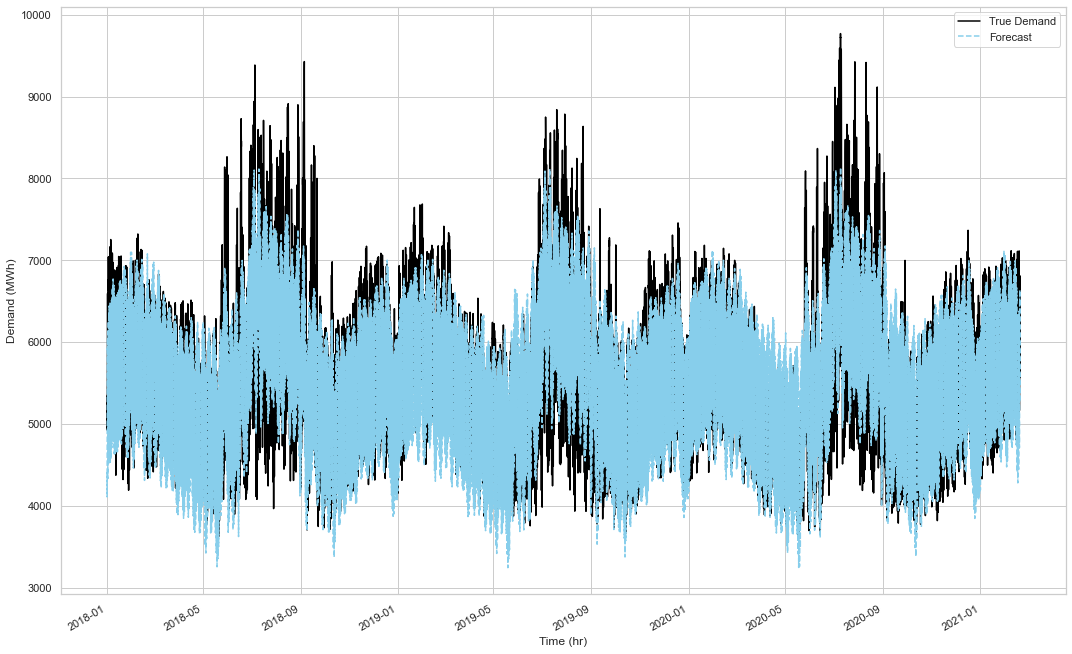

In [52]:
df_6 = fourier_terms_year_day(data_2,K1_4,K2_4)

df_6['demand'] = df_6.pop('demand')

X_train_6, X_test_6, y_train_6, y_test_6 = my_data(df_6,'2021-01-20')

X_train_6 = sm.add_constant(X_train_6)
X_test_6 = sm.add_constant(X_test_6)

model_6 = sm.OLS(y_train_6,X_train_6).fit()
predictions_6 = model_6.predict(X_test_6)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_6.predict(sm.add_constant(df_6.loc[:, df_6.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [128]:
data_4 = data_3.copy()
data_3.drop(['temperature'],axis=1,inplace=True)
display(data_3.head())
display(data_3.shape)

,temp_index,week_index,demand,holiday_idx
timestamp,,,,
2018-01-01 00:00:00,0,1,5340.0,0
2018-01-01 01:00:00,0,1,5211.0,0
2018-01-01 02:00:00,0,1,5096.0,0
2018-01-01 03:00:00,0,1,4987.0,0
2018-01-01 04:00:00,0,1,4926.0,0


(27501, 4)

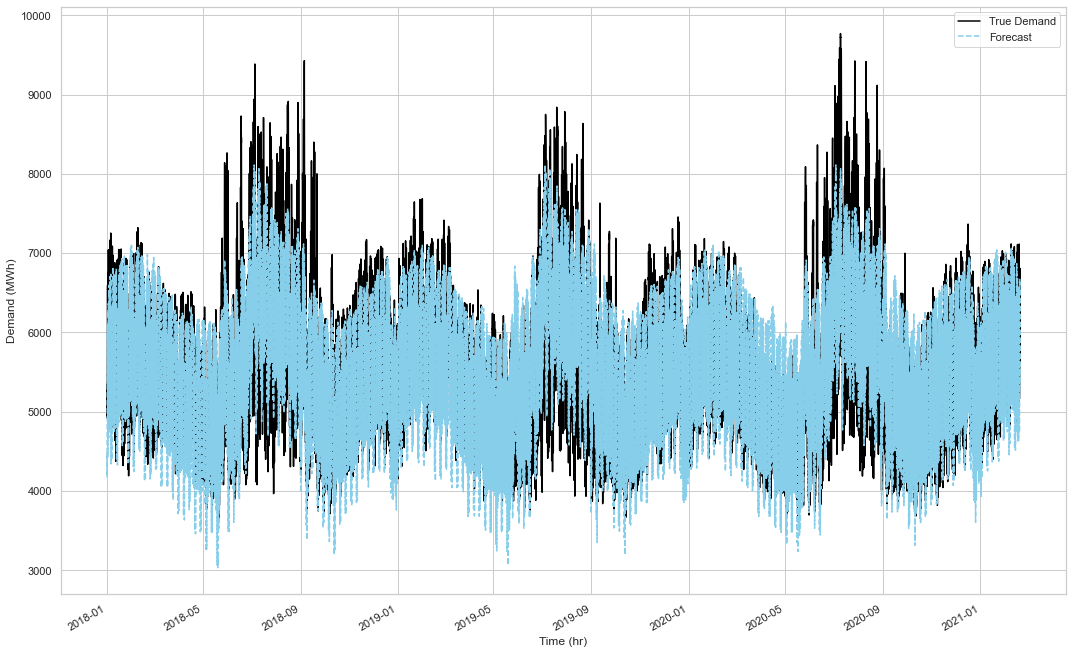

In [57]:
df_7 = fourier_terms_year_day(data_3,K1_4,K2_4)

df_7['demand'] = df_7.pop('demand')

X_train_7, X_test_7, y_train_7, y_test_7 = my_data(df_7,'2021-01-20')

X_train_7 = sm.add_constant(X_train_7)
X_test_7 = sm.add_constant(X_test_7)

model_7 = sm.OLS(y_train_7,X_train_7).fit()
predictions_7 = model_7.predict(X_test_7)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_7.predict(sm.add_constant(df_7.loc[:, df_7.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [129]:
data_5 = data_4.copy()
data_4.drop(['temperature','temp_index'],axis=1,inplace=True)
display(data_4.head())
display(data_4.shape)

,week_index,demand,holiday_idx
timestamp,,,
2018-01-01 00:00:00,1,5340.0,0
2018-01-01 01:00:00,1,5211.0,0
2018-01-01 02:00:00,1,5096.0,0
2018-01-01 03:00:00,1,4987.0,0
2018-01-01 04:00:00,1,4926.0,0


(27501, 3)

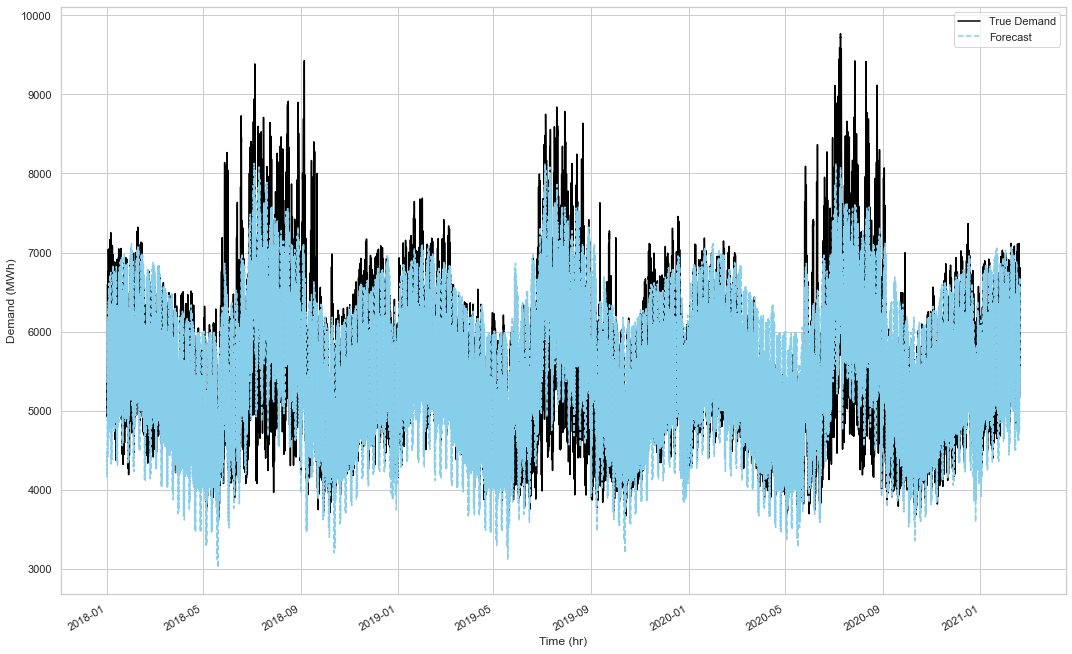

In [64]:
df_8 = fourier_terms_year_day(data_4,K1_4,K2_4)

df_8['demand'] = df_8.pop('demand')

X_train_8, X_test_8, y_train_8, y_test_8 = my_data(df_8,'2021-01-20')

X_train_8 = sm.add_constant(X_train_8)
X_test_8 = sm.add_constant(X_test_8)

model_8 = sm.OLS(y_train_8,X_train_8).fit()
predictions_8 = model_8.predict(X_test_8)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_8.predict(sm.add_constant(df_8.loc[:, df_8.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [130]:
data_6 = data_5.copy()
data_5.drop(['temperature','temp_index','week_index'],axis=1,inplace=True)
display(data_5.head())
display(data_5.shape)

,demand,holiday_idx
timestamp,,
2018-01-01 00:00:00,5340.0,0
2018-01-01 01:00:00,5211.0,0
2018-01-01 02:00:00,5096.0,0
2018-01-01 03:00:00,4987.0,0
2018-01-01 04:00:00,4926.0,0


(27501, 2)

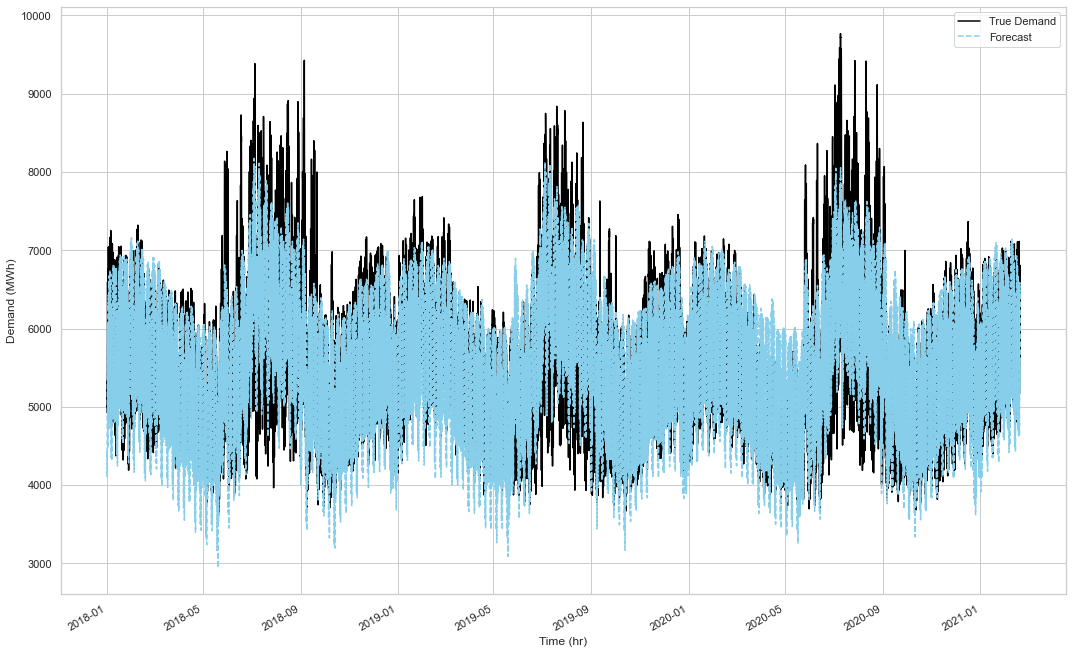

In [70]:
df_9 = fourier_terms_year_week_day(data_5,K1_3,K2_3,K3_3)

df_9['demand'] = df_9.pop('demand')

X_train_9, X_test_9, y_train_9, y_test_9 = my_data(df_9,'2021-01-20')

X_train_9 = sm.add_constant(X_train_9)
X_test_9 = sm.add_constant(X_test_9)

model_9 = sm.OLS(y_train_9,X_train_9).fit()
predictions_9 = model_9.predict(X_test_9)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_9.predict(sm.add_constant(df_9.loc[:, df_9.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [131]:
data_7 = data_6.copy()
data_6.drop(['temp_index','week_index'],axis=1,inplace=True)
display(data_6.head())
display(data_6.shape)

,temperature,demand,holiday_idx
timestamp,,,
2018-01-01 00:00:00,-19.5,5340.0,0
2018-01-01 01:00:00,-21.7,5211.0,0
2018-01-01 02:00:00,-19.3,5096.0,0
2018-01-01 03:00:00,-20.3,4987.0,0
2018-01-01 04:00:00,-19.9,4926.0,0


(27501, 3)

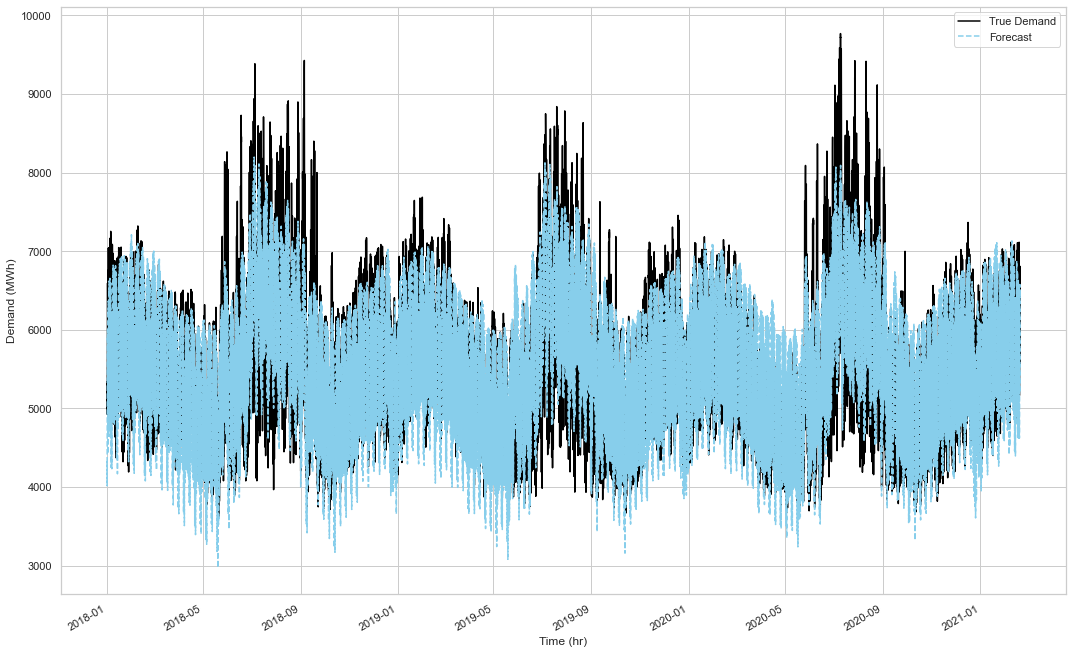

In [109]:
df_10 = fourier_terms_year_week_day(data_6,K1_3,K2_3,K3_3)

df_10['demand'] = df_10.pop('demand')

X_train_10, X_test_10, y_train_10, y_test_10 = my_data(df_10,'2021-01-20')

X_train_10 = sm.add_constant(X_train_10)
X_test_10 = sm.add_constant(X_test_10)

model_10 = sm.OLS(y_train_10,X_train_10).fit()
predictions_10 = model_10.predict(X_test_10)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_10.predict(sm.add_constant(df_10.loc[:, df_10.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [110]:
model_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     543.2
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:06:08   Log-Likelihood:            -2.0130e+05
No. Observations:               26757   AIC:                         4.030e+05
Df Residuals:                   26558   BIC:                         4.046e+05
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5628.6135      6.737    835.514      0.000    5615.409    5641.818
temperature     6.5809      0.668      9.857      0.000       5.272       7.890
holiday_idx    57.9899     32.739      1.771      0.077      -6.180     122.159
sin_year1     -73.1993      5.388    -13.585      0.000     -83.760     -62.638
cos_year1     -42.3484      9.257     -4.575      0.000     -60.492     -24.205
sin_year2     414.7943      3.944    105.175      0.000     407.064     422.525
cos_year2     376.5794      3.926     95.908      0.000     368.883     384.275
sin_year3    -195.6049      3.906    -50.078      0.000    -203.261    -187.949
cos_year3    -152.0447      3.885    -39.135      0.000    -159.660    -144.430
sin_year4      34.5752      3.911      8.840      0.000      26.909      42.241
cos_year4     -43.4264      3.912    -11.101      0.000     -51.094     -35.759
sin_year5      -6.7947      3.896     -1.744      0.081     -14.432       0.842
cos_year5    -102.2213      3.903    -26.188      0.000    -109.872     -94.571
sin_year6      41.3591      3.890     10.631      0.000      33.734      48.984
cos_year6     -12.3007      3.904     -3.151      0.002     -19.952      -4.649
sin_year7     -15.5329      3.893     -3.989      0.000     -23.164      -7.902
cos_year7     -54.2826      3.901    -13.916      0.000     -61.928     -46.637
sin_year8      48.5804      3.893     12.479      0.000      40.950      56.211
cos_year8      -8.0825      3.926     -2.059      0.040     -15.778      -0.387
sin_year9     -62.3034      3.895    -15.995      0.000     -69.938     -54.669
cos_year9     -82.9478      3.898    -21.279      0.000     -90.588     -75.307
sin_year10     53.0638      3.911     13.569      0.000      45.399      60.729
cos_year10     -1.6705      3.902     -0.428      0.669      -9.318       5.977
sin_year11     10.1983      3.898      2.616      0.009       2.558      17.839
cos_year11    -30.7486      3.901     -7.882      0.000     -38.395     -23.102
sin_year12      8.3409      3.908      2.134      0.033       0.680      16.001
cos_year12    -11.4703      3.918     -2.928      0.003     -19.150      -3.791
sin_year13     41.0654      3.900     10.530      0.000      33.422      48.709
cos_year13    -69.5834      3.895    -17.865      0.000     -77.218     -61.949
sin_year14     23.7969      3.901      6.100      0.000      16.151      31.443
cos_year14     -9.2335      3.895     -2.371      0.018     -16.868      -1.599
sin_year15     32.5447      3.904      8.335      0.000      24.892      40.197
cos_year15    -13.2008      3.906     -3.379      0.001     -20.857      -5.544
sin_year16      6.8117      3.897      1.748      0.080      -0.826      14.450
cos_year16    -27.7691      3.907     -7.107      0.000     -35.428     -20.110
sin_year17    -11.7267      3.892     -3.01

In [132]:
data_8 = data_7.copy()
data_8.drop(['temperature','temp_index','week_index'],axis=1,inplace=True)
display(data_8.head())
display(data_8.shape)

,demand,holiday_idx
timestamp,,
2018-01-01 00:00:00,5340.0,0
2018-01-01 01:00:00,5211.0,0
2018-01-01 02:00:00,5096.0,0
2018-01-01 03:00:00,4987.0,0
2018-01-01 04:00:00,4926.0,0


(27501, 2)

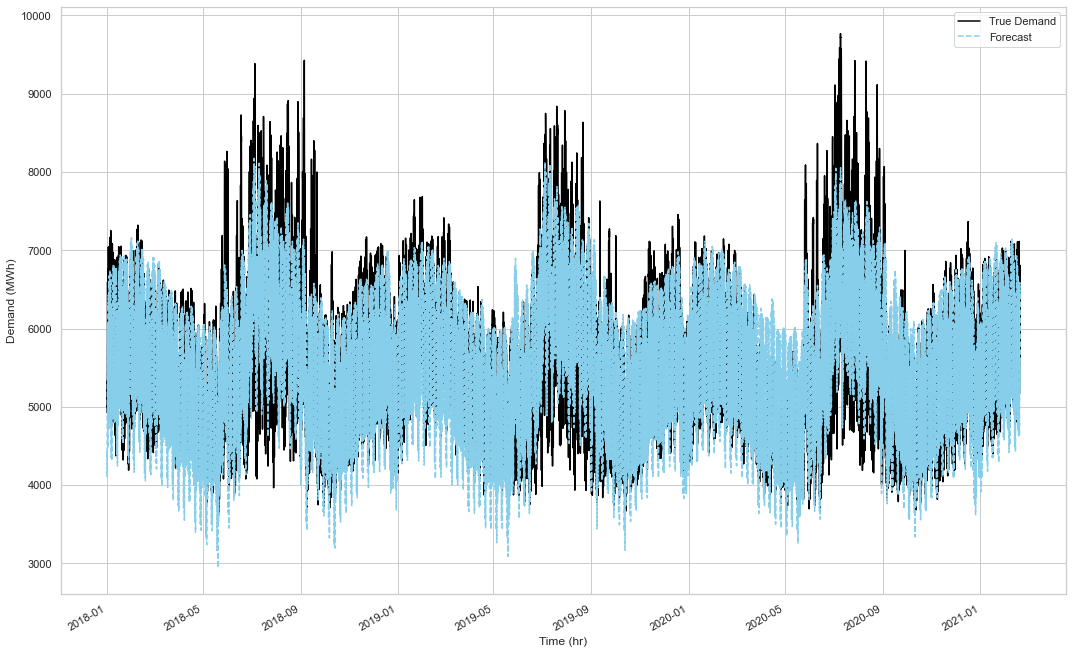

In [133]:
df_11 = fourier_terms_year_week_day(data_8,K1_3,K2_3,K3_3)

df_11['demand'] = df_11.pop('demand')

X_train_11, X_test_11, y_train_11, y_test_11 = my_data(df_11,'2021-01-20')

X_train_11 = sm.add_constant(X_train_11)
X_test_11 = sm.add_constant(X_test_11)

model_11 = sm.OLS(y_train_11,X_train_11).fit()
predictions_11 = model_11.predict(X_test_11)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_11.predict(sm.add_constant(df_11.loc[:, df_11.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [134]:
print(f'Model 1 AIC: {model_1.aic}')
print(f'Model 2 AIC: {model_2.aic}')
print(f'Model 3 AIC: {model_3.aic}')
print(f'Model 4 AIC: {model_4.aic}')
print(f'Model 5 AIC: {model_5.aic}')
print(f'Model 6 AIC: {model_6.aic}')
print(f'Model 7 AIC: {model_7.aic}')
print(f'Model 8 AIC: {model_8.aic}')
print(f'Model 9 AIC: {model_9.aic}')
print(f'Model 10 AIC: {model_10.aic}')
print(f'Model 11 AIC: {model_11.aic}')

Model 1 AIC: 437623.1123607759
Model 2 AIC: 436300.85643772036
Model 3 AIC: 403102.0702631051
Model 4 AIC: 407466.515701666
Model 5 AIC: 402979.2063366022
Model 6 AIC: 407103.9190812204
Model 7 AIC: 402986.785264414
Model 8 AIC: 403313.9907995092
Model 9 AIC: 403099.67623245023
Model 10 AIC: 403003.96217239904
Model 11 AIC: 403099.67623245023


In [138]:
MAE_1 = np.sum(np.abs(data['demand'] - model_1.predict(sm.add_constant(df_1.loc[:, df_1.columns != 'demand']))))/data.shape[0]
MAE_2 = np.sum(np.abs(data['demand'] - model_2.predict(sm.add_constant(df_2.loc[:, df_2.columns != 'demand']))))/data.shape[0]
MAE_3 = np.sum(np.abs(data['demand'] - model_3.predict(sm.add_constant(df_3.loc[:, df_3.columns != 'demand']))))/data.shape[0]
MAE_4 = np.sum(np.abs(data['demand'] - model_4.predict(sm.add_constant(df_4.loc[:, df_4.columns != 'demand']))))/data.shape[0]
MAE_5 = np.sum(np.abs(data['demand'] - model_5.predict(sm.add_constant(df_5.loc[:, df_5.columns != 'demand']))))/data.shape[0]
MAE_6 = np.sum(np.abs(data['demand'] - model_6.predict(sm.add_constant(df_6.loc[:, df_6.columns != 'demand']))))/data.shape[0]
MAE_7 = np.sum(np.abs(data['demand'] - model_7.predict(sm.add_constant(df_7.loc[:, df_7.columns != 'demand']))))/data.shape[0]
MAE_8 = np.sum(np.abs(data['demand'] - model_8.predict(sm.add_constant(df_8.loc[:, df_8.columns != 'demand']))))/data.shape[0]
MAE_9 = np.sum(np.abs(data['demand'] - model_9.predict(sm.add_constant(df_9.loc[:, df_9.columns != 'demand']))))/data.shape[0]
MAE_10 = np.sum(np.abs(data['demand'] - model_10.predict(sm.add_constant(df_10.loc[:, df_10.columns != 'demand']))))/data.shape[0]
MAE_11 = np.sum(np.abs(data['demand'] - model_11.predict(sm.add_constant(df_11.loc[:, df_11.columns != 'demand']))))/data.shape[0]

In [136]:
print(f'Model 1 MAE: {MAE_1}')
print(f'Model 2 MAE: {MAE_2}')
print(f'Model 3 MAE: {MAE_3}')
print(f'Model 4 MAE: {MAE_4}')
print(f'Model 5 MAE: {MAE_5}')
print(f'Model 6 MAE: {MAE_6}')
print(f'Model 7 MAE: {MAE_7}')
print(f'Model 8 MAE: {MAE_8}')
print(f'Model 9 MAE: {MAE_9}')
print(f'Model 10 MAE: {MAE_10}')
print(f'Model 11 MAE: {MAE_11}')

Model 1 MAE: 702.7552149498346
Model 2 MAE: 680.2482950629773
Model 3 MAE: 332.70699042885
Model 4 MAE: 366.3607468941646
Model 5 MAE: 333.8856569950135
Model 6 MAE: 365.82651285963215
Model 7 MAE: 332.751940097946
Model 8 MAE: 334.14192073614555
Model 9 MAE: 332.8072420128815
Model 10 MAE: 335.7274150912956
Model 11 MAE: 332.8072420128815


In [91]:
sarima_errors_3 = data.loc[:'2021-01-19']['demand'] - model_3.predict(sm.add_constant(df_3.loc[:'2021-01-19'].loc[:, df_3.columns != 'demand']))

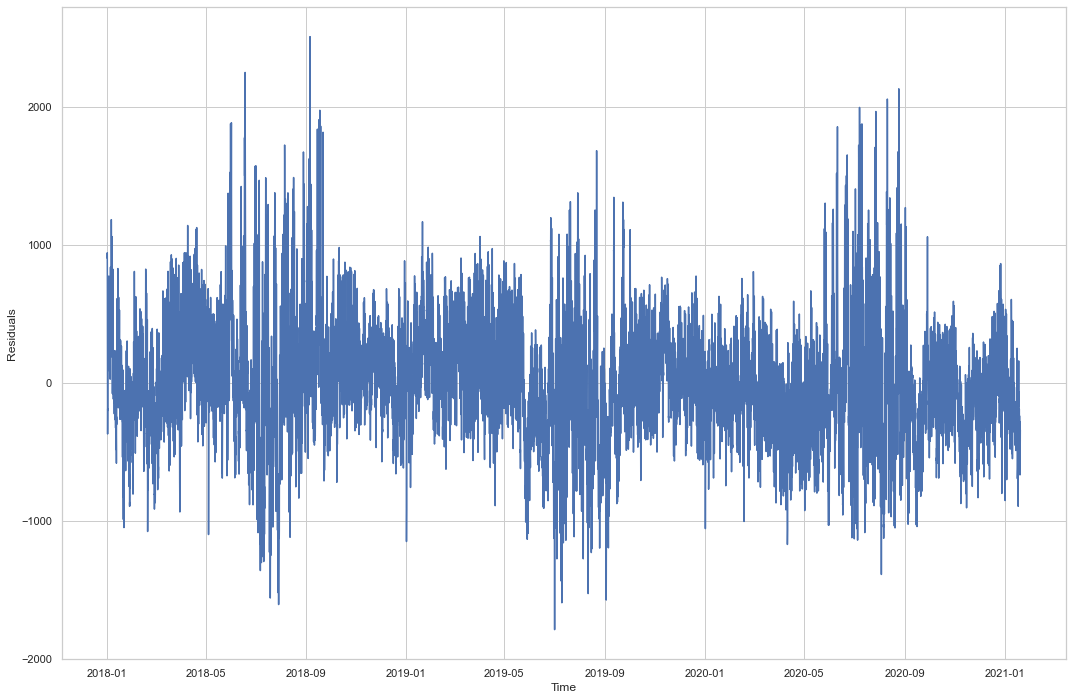

In [143]:
plt.plot(sarima_errors_3);
plt.xlabel('Time');
plt.ylabel('Residuals');

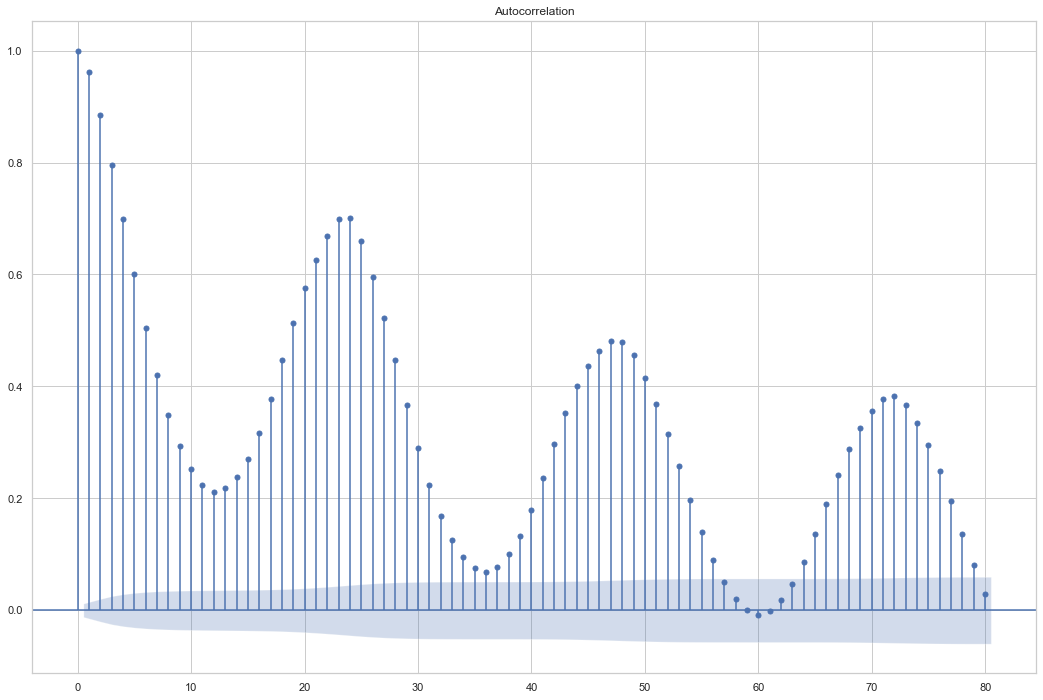

In [152]:
plot_acf(sarima_errors_3,lags=80);

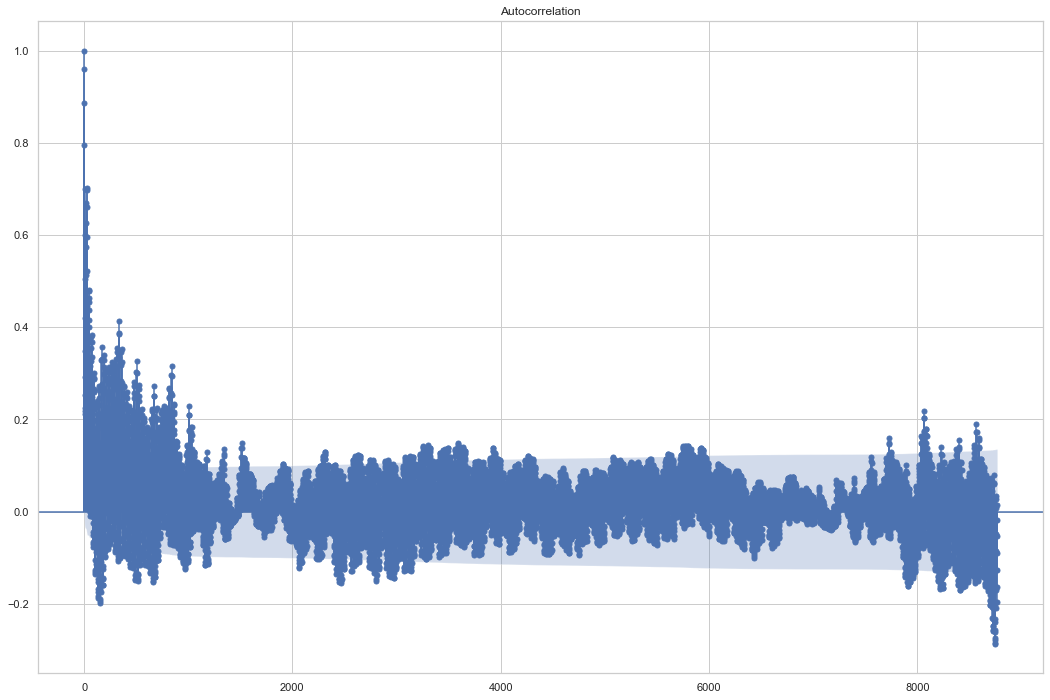

In [150]:
plot_acf(sarima_errors_3,lags=8766);

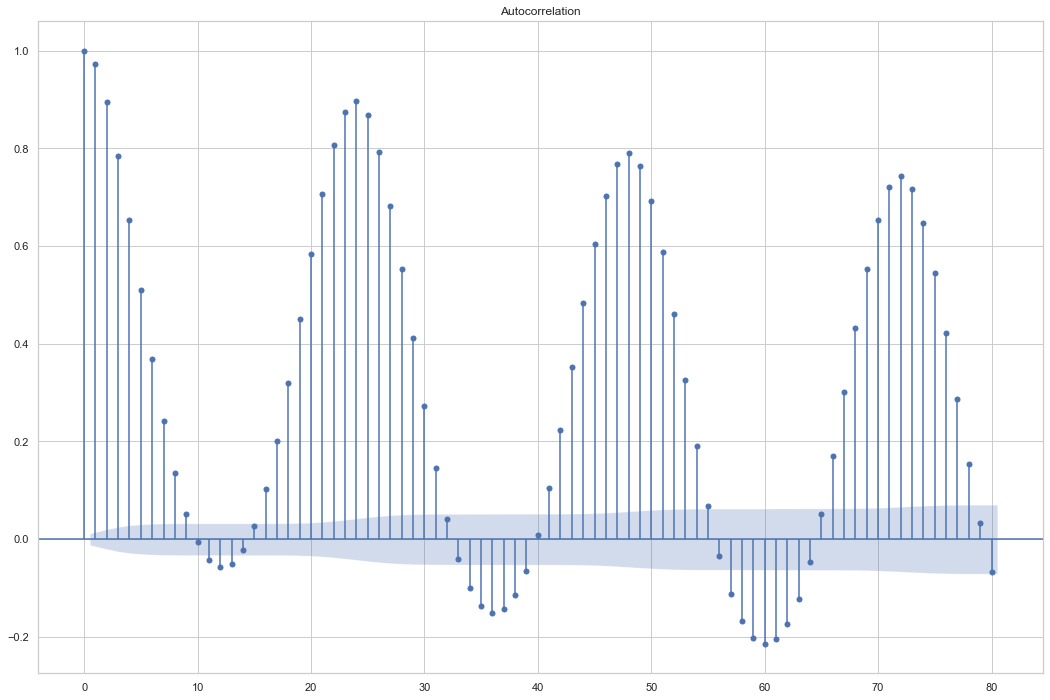

In [154]:
plot_acf(data['demand'],lags=80);

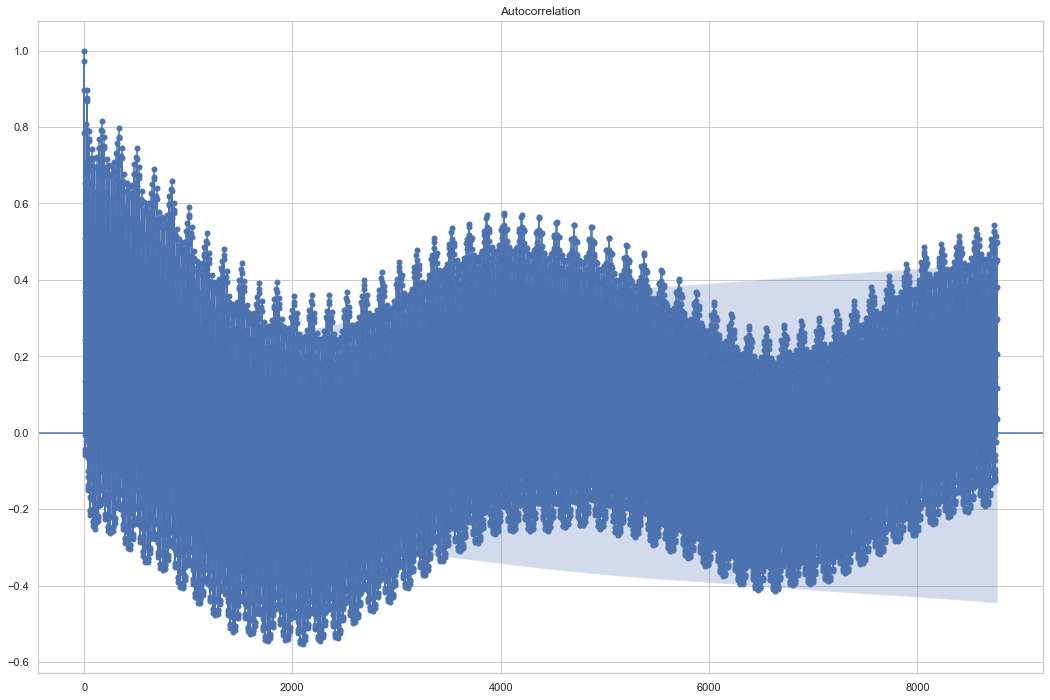

In [149]:
plot_acf(data['demand'],lags=8766);

In [94]:
stl = STL(sarima_errors_3,period=24)

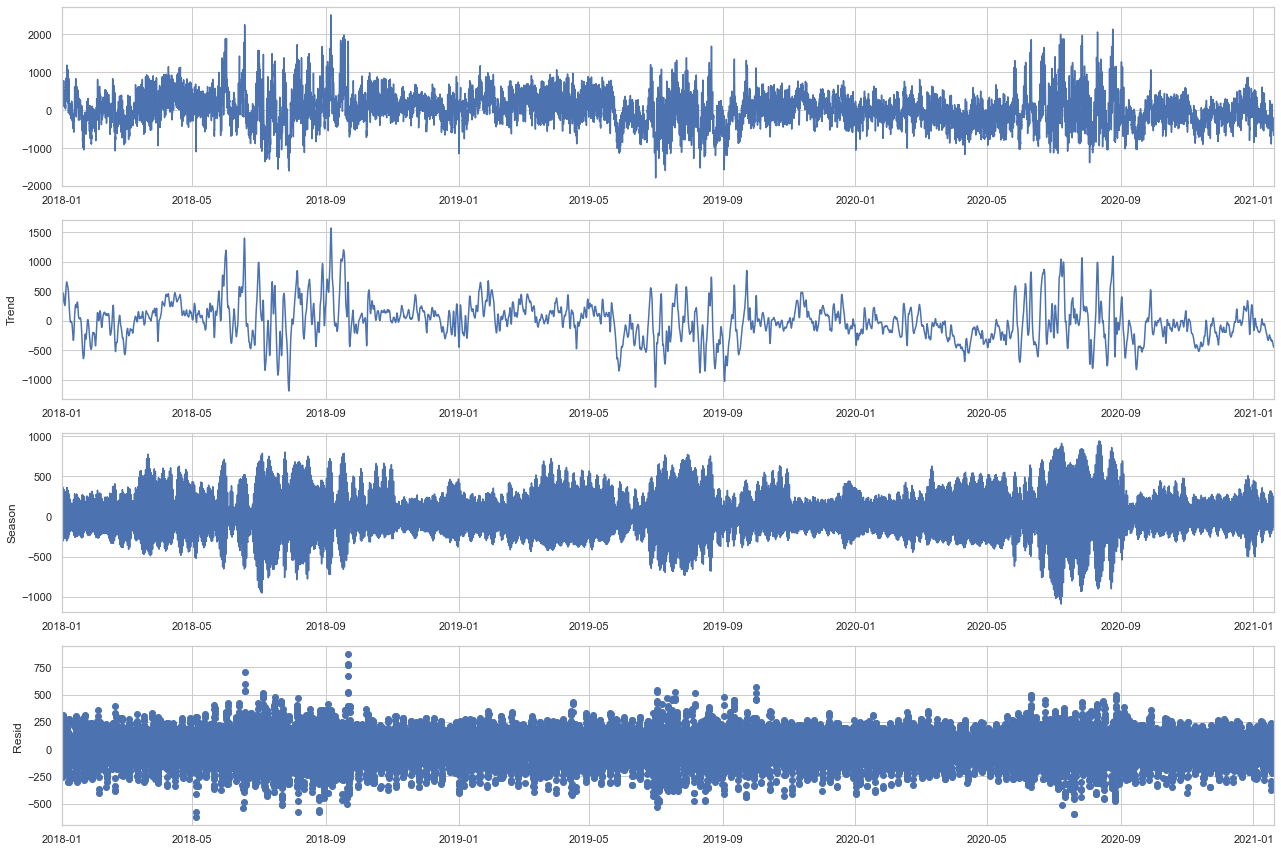

In [95]:
stl.fit().plot();

In [96]:
adf_test = pm.arima.ADFTest(alpha=0.05)
display(adf_test.should_diff(sarima_errors_5))

(0.01, False)

In [169]:
with open('sarima_residuals.pkl','wb') as f:
    pickle.dump(sarima_errors_3, f)

In [ ]:
sarima_model = pm.auto_arima(y = sarima_errors_3,
                              start_p = 0,
                              d = 1,
                              start_q = 0,
                              max_p = 2,
                              max_d = 2,
                              max_q = 2,
                              start_P = 0,
                              D = 1,
                              start_Q = 0,
                              max_P = 2,
                              max_D = 2,
                              max_Q = 2,
                              m = 24,
                              seasonal = True,
                              information_criterion = 'aic',
                              trace = True,
                              suppress_warnings = True,
                              max_iters = 10 
                             )

Performing stepwise search to minimize aic


MemoryError: Unable to allocate 138. MiB for an array with shape (26, 26, 26758) and data type float64